# CIFAR-100 Training - Optimized for 74% Accuracy with HuggingFace Integration

## Key Improvements:
- Fixed data augmentation (proper Cutout implementation)
- Cosine annealing scheduler with warmup
- Optimized hyperparameters (batch size 256, MixUp alpha 0.2)
- Label smoothing (0.1)
- Gradient clipping
- Mixed precision training
- Model checkpointing and early stopping
- WideResNet-28-10 (36.5M parameters)
- **HuggingFace Hub integration with checkpoint uploads at breakpoints**

In [1]:
# Import Libraries
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# HuggingFace Setup - Get token from Colab secrets
try:
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("✓ HuggingFace token retrieved from Colab secrets")
except Exception as e:
    print(f"Warning: Could not retrieve HF_TOKEN from secrets: {e}")
    print("Please add HF_TOKEN to Colab secrets for model upload")
    HF_TOKEN = None

# Install huggingface_hub if needed
try:
    from huggingface_hub import HfApi, create_repo, upload_file
except ImportError:
    !pip install -q huggingface_hub
    from huggingface_hub import HfApi, create_repo, upload_file

# Configure HuggingFace repository
REPO_ID = 'pandurangpatil/cifar100-wideresnet-session8'
api = HfApi()

# Login and create repository
if HF_TOKEN:
    try:
        api.set_access_token(HF_TOKEN)
        create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True, token=HF_TOKEN)
        print(f"✓ Repository ready: https://huggingface.co/{REPO_ID}")
    except Exception as e:
        print(f"Warning: Could not create repository: {e}")
else:
    print("⚠ HuggingFace upload will be skipped (no token available)")

✓ HuggingFace token retrieved from Colab secrets


In [3]:
# Improved Data Augmentation
class ImprovedAlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5, fill_value=0),  # Cutout
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Instantiate transforms
train_transforms = ImprovedAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

# CIFAR-100 Dataset with increased batch size
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# DataLoaders with batch size 256
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

cifar100_classes = datasets.CIFAR100(root='./data', train=False).classes
print(f"Training batches: {len(train_loader)}, Test batches: {len(test_loader)}")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3644917854.py:7: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=8, max_width=8, p=0.5, fill_value=0),  # Cutout
100%|██████████| 169M/169M [00:03<00:00, 42.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training batches: 196, Test batches: 40


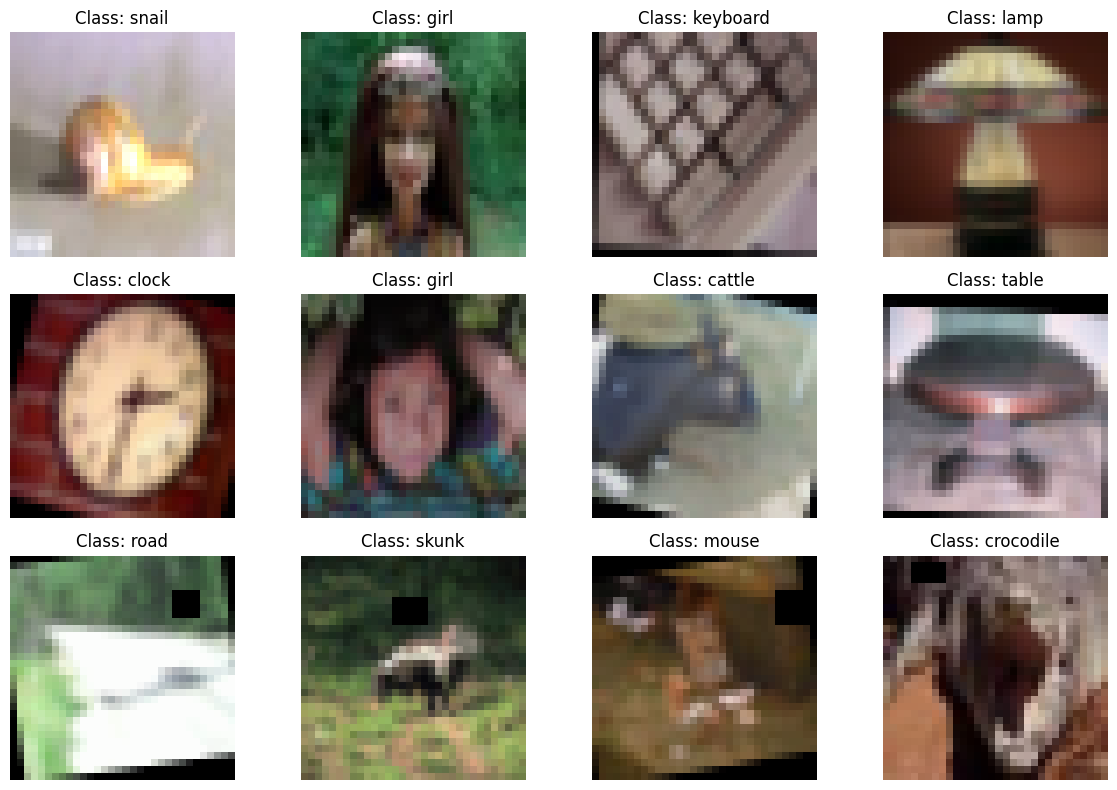

In [4]:
# Visualize augmented samples
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))
batch_data = batch_data.cpu().detach()

fig = plt.figure(figsize=(12, 8))
for i in range(12):
    img = batch_data[i].numpy().transpose((1, 2, 0))
    # Denormalize
    img = img * np.array(cifar100_std) + np.array(cifar100_mean)
    img = np.clip(img, 0, 1)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {cifar100_classes[batch_label[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_augmentations.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# WideResNet Architecture
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.equalInOut = in_planes == out_planes
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropRate = dropRate
        self.shortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, 1, stride=stride, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.conv1(out if self.equalInOut else x)
        out = self.relu2(self.bn2(out))
        if self.dropRate > 0:
            out = F.dropout(out, p=self.dropRate, training=self.training)
        out = self.conv2(out)
        return out + (x if self.equalInOut else self.shortcut(x))


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=100, widen_factor=10, dropRate=0.3):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) // 6
        block = BasicBlock
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [6]:
# Initialize model
model = WideResNet(depth=28, widen_factor=10, dropRate=0.3, num_classes=100).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]          23,040
       BatchNorm2d-5          [-1, 160, 32, 32]             320
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32]         230,400
            Conv2d-8          [-1, 160, 32, 32]           2,560
        BasicBlock-9          [-1, 160, 32, 32]               0
      BatchNorm2d-10          [-1, 160, 32, 32]             320
             ReLU-11          [-1, 160, 32, 32]               0
           Conv2d-12          [-1, 160, 32, 32]         230,400
      BatchNorm2d-13          [-1, 160, 32, 32]             320
             ReLU-14          [-1, 160,

In [7]:
# MixUp function
def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [8]:
# Learning Rate Warmup Scheduler
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, steps_per_epoch):
        self.optimizer = optimizer
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.current_step = 0

    def step(self):
        if self.current_step < self.warmup_steps:
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * self.current_step / self.warmup_steps
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_step += 1

    def is_warmup(self):
        return self.current_step < self.warmup_steps

In [9]:
# HuggingFace Upload Functions
def upload_to_huggingface(file_path, path_in_repo, repo_id=REPO_ID, commit_message="Upload checkpoint"):
    """Upload a file to HuggingFace Hub"""
    if not HF_TOKEN:
        print("⚠ Skipping upload (no HF token)")
        return

    try:
        api.upload_file(
            path_or_fileobj=file_path,
            path_in_repo=path_in_repo,
            repo_id=repo_id,
            repo_type="model",
            token=HF_TOKEN,
            commit_message=commit_message
        )
        print(f"✓ Uploaded: {path_in_repo}")
    except Exception as e:
        print(f"✗ Upload failed for {path_in_repo}: {e}")

def save_and_upload_checkpoint(model, optimizer, epoch, train_acc, test_acc, train_loss, test_loss,
                                checkpoint_dir, checkpoint_name, is_best=False):
    """Save checkpoint locally and upload to HuggingFace"""
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

    # Save checkpoint with metadata
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'timestamp': datetime.now().isoformat(),
        'config': {
            'model': 'WideResNet-28-10',
            'batch_size': BATCH_SIZE,
            'mixup_alpha': 0.2,
            'label_smoothing': 0.1,
            'weight_decay': 1e-3,
            'dropout': 0.3
        }
    }

    torch.save(checkpoint, checkpoint_path)

    # Upload to HuggingFace
    commit_msg = f"Epoch {epoch}: Test Acc {test_acc:.2f}%"
    if is_best:
        commit_msg = f"New best model! " + commit_msg

    upload_to_huggingface(checkpoint_path, checkpoint_name, commit_message=commit_msg)

    return checkpoint_path

def create_and_upload_model_card(best_acc, total_epochs, train_accuracies, test_accuracies, checkpoint_dir):
    """Create and upload README.md model card"""
    model_card = f"""---
tags:
- image-classification
- cifar100
- wideresnet
- pytorch
datasets:
- cifar100
metrics:
- accuracy
---

# CIFAR-100 WideResNet-28-10

## Model Description

WideResNet-28-10 trained on CIFAR-100 dataset with advanced augmentation techniques.

### Model Architecture
- **Architecture**: WideResNet-28-10
- **Parameters**: 36.5M
- **Depth**: 28 layers
- **Width Factor**: 10
- **Dropout**: 0.3

### Training Configuration
- **Batch Size**: 256
- **Optimizer**: SGD (momentum=0.9, weight_decay=1e-3)
- **Learning Rate**: Cosine annealing with warmup (0.01→0.1, min=1e-4)
- **Scheduler**: CosineAnnealingWarmRestarts (T_0=25)
- **Augmentation**: HorizontalFlip, ShiftScaleRotate, Cutout, ColorJitter
- **MixUp**: Alpha=0.2
- **Label Smoothing**: 0.1
- **Mixed Precision**: Enabled
- **Gradient Clipping**: 1.0

### Performance
- **Best Test Accuracy**: {best_acc:.2f}%
- **Total Epochs Trained**: {total_epochs}
- **Final Train Accuracy**: {train_accuracies[-1]:.2f}%
- **Final Test Accuracy**: {test_accuracies[-1]:.2f}%

### Available Checkpoints
- `best_model.pth` - Best performing model
- `checkpoint_epoch10.pth` - Epoch 10 checkpoint
- `checkpoint_epoch25.pth` - Epoch 25 checkpoint (end of cycle 1)
- `checkpoint_epoch50.pth` - Epoch 50 checkpoint (mid-training)
- `checkpoint_epoch75.pth` - Epoch 75 checkpoint (late training)
- `final_model.pth` - Final epoch model

### Usage

```python
import torch
from huggingface_hub import hf_hub_download

# Download model
checkpoint_path = hf_hub_download(
    repo_id="{REPO_ID}",
    filename="best_model.pth"
)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Load model (define WideResNet class first)
model = WideResNet(depth=28, widen_factor=10, num_classes=100)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```

### Training Details
- **Dataset**: CIFAR-100 (50,000 train, 10,000 test)
- **Classes**: 100
- **Image Size**: 32×32
- **Normalization**: mean=(0.5071, 0.4865, 0.4409), std=(0.2673, 0.2564, 0.2761)

### Files
- `training_curves.png` - Training/test accuracy and loss curves
- `metrics.json` - Complete training history
- `config.json` - Hyperparameter configuration

### License
MIT

### Citation
```bibtex
@misc{{wideresnet-cifar100,
  author = {{Pandurang Patil}},
  title = {{CIFAR-100 WideResNet-28-10}},
  year = {{2025}},
  publisher = {{HuggingFace}},
  url = {{https://huggingface.co/{REPO_ID}}}
}}
```
"""

    # Save README locally
    readme_path = os.path.join(checkpoint_dir, 'README.md')
    with open(readme_path, 'w') as f:
        f.write(model_card)

    # Upload to HuggingFace
    upload_to_huggingface(readme_path, 'README.md', commit_message="Update model card")
    print("✓ Model card created and uploaded")

In [10]:
# Training function with mixed precision and gradient clipping
def train(model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
          use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    total_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with autocast():
            if use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
                outputs = model(inputs)
                loss = lam * F.cross_entropy(outputs, targets_a, label_smoothing=label_smoothing) + \
                       (1 - lam) * F.cross_entropy(outputs, targets_b, label_smoothing=label_smoothing)
            else:
                outputs = model(data)
                loss = F.cross_entropy(outputs, target, label_smoothing=label_smoothing)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Update learning rate
        if warmup_scheduler.is_warmup():
            warmup_scheduler.step()
        else:
            scheduler.step()

        # Accuracy tracking
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)
        total_loss += loss.item()

        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}% LR={current_lr:.6f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / processed
    return avg_loss, accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")
    return test_loss, accuracy

In [11]:
# Training Configuration
print("=" * 70)
print("Training Configuration:")
print("=" * 70)
print(f"Model: WideResNet-28-10 (36.5M parameters)")
print(f"Batch Size: {BATCH_SIZE}")
print(f"MixUp Alpha: 0.2")
print(f"Label Smoothing: 0.1")
print(f"Weight Decay: 1e-3")
print(f"Gradient Clipping: 1.0")
print(f"Scheduler: CosineAnnealingWarmRestarts")
print(f"Warmup: 5 epochs (0.01 -> 0.1)")
print(f"Mixed Precision: Enabled")
print(f"HuggingFace Upload: {'Enabled' if HF_TOKEN else 'Disabled'}")
print("=" * 70)

# Optimizer and Scheduler
EPOCHS = 100
WARMUP_EPOCHS = 5
INITIAL_LR = 0.01
MAX_LR = 0.1
MIN_LR = 1e-4

optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=0.9, weight_decay=1e-3)

# Cosine annealing with warm restarts (T_0 = 25 epochs per cycle)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=MIN_LR)

# Warmup scheduler
warmup_scheduler = WarmupScheduler(optimizer, WARMUP_EPOCHS, INITIAL_LR, MAX_LR, len(train_loader))

# Gradient scaler for mixed precision
scaler = GradScaler()

# Tracking variables
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
learning_rates = []

# Early stopping and checkpointing
best_test_acc = 0.0
patience = 15
patience_counter = 0
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint breakpoints
CHECKPOINT_EPOCHS = [10, 20, 25, 30, 40, 50, 60, 75, 90]

Training Configuration:
Model: WideResNet-28-10 (36.5M parameters)
Batch Size: 256
MixUp Alpha: 0.2
Label Smoothing: 0.1
Weight Decay: 1e-3
Gradient Clipping: 1.0
Scheduler: CosineAnnealingWarmRestarts
Warmup: 5 epochs (0.01 -> 0.1)
Mixed Precision: Enabled
HuggingFace Upload: Enabled


/tmp/ipython-input-3987618151.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [12]:
# Training Loop with HuggingFace Checkpoint Uploads
print("\nStarting training...\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train(
        model, device, train_loader, optimizer, scheduler, warmup_scheduler, scaler, epoch,
        use_mixup=True, mixup_alpha=0.2, label_smoothing=0.1
    )

    # Test
    test_loss, test_acc = test(model, device, test_loader)

    # Record metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0

        # Save and upload best model
        print(f"*** New best model! Test Accuracy: {best_test_acc:.2f}% ***")
        save_and_upload_checkpoint(
            model, optimizer, epoch, train_acc, test_acc, train_loss, test_loss,
            checkpoint_dir, 'best_model.pth', is_best=True
        )
    else:
        patience_counter += 1

    # Upload checkpoint at breakpoints
    if epoch in CHECKPOINT_EPOCHS:
        checkpoint_name = f'checkpoint_epoch{epoch}.pth'
        print(f"📍 Breakpoint checkpoint at epoch {epoch}")
        save_and_upload_checkpoint(
            model, optimizer, epoch, train_acc, test_acc, train_loss, test_loss,
            checkpoint_dir, checkpoint_name
        )

    # Save metrics periodically
    if epoch % 10 == 0 or epoch in CHECKPOINT_EPOCHS:
        metrics = {
            'epochs': list(range(1, epoch + 1)),
            'train_losses': train_losses,
            'test_losses': test_losses,
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'learning_rates': learning_rates,
            'best_test_accuracy': best_test_acc
        }
        metrics_path = os.path.join(checkpoint_dir, 'metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(metrics, f, indent=2)

        upload_to_huggingface(metrics_path, 'metrics.json', commit_message=f"Update metrics (epoch {epoch})")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}. No improvement for {patience} epochs.")
        break

    # Check if target reached
    if test_acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {test_acc:.2f}%")
        print(f"{'=' * 70}")
        break

    print(f"Best Test Accuracy so far: {best_test_acc:.2f}% | Patience: {patience_counter}/{patience}\n")

# Save final model
print("\n📦 Saving final model...")
save_and_upload_checkpoint(
    model, optimizer, epoch, train_acc, test_acc, train_loss, test_loss,
    checkpoint_dir, 'final_model.pth'
)

print(f"\nTraining completed. Best test accuracy: {best_test_acc:.2f}%")


Starting training...



  0%|          | 0/196 [00:00<?, ?it/s]/tmp/ipython-input-1052289112.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Loss=4.4748 Acc=4.28% LR=0.027908: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]



Test set: Average loss: 4.0935, Accuracy: 664/10000 (6.64%)

*** New best model! Test Accuracy: 6.64% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 6.64% | Patience: 0/15



Epoch 2 Loss=3.9219 Acc=10.35% LR=0.045908: 100%|██████████| 196/196 [01:49<00:00,  1.79it/s]



Test set: Average loss: 3.6983, Accuracy: 1282/10000 (12.82%)

*** New best model! Test Accuracy: 12.82% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 12.82% | Patience: 0/15



Epoch 3 Loss=4.2744 Acc=16.26% LR=0.063908: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 3.1793, Accuracy: 2206/10000 (22.06%)

*** New best model! Test Accuracy: 22.06% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 22.06% | Patience: 0/15



Epoch 4 Loss=3.1342 Acc=21.40% LR=0.081908: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.9839, Accuracy: 2559/10000 (25.59%)

*** New best model! Test Accuracy: 25.59% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 25.59% | Patience: 0/15



Epoch 5 Loss=4.2816 Acc=26.83% LR=0.099908: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.8263, Accuracy: 2937/10000 (29.37%)

*** New best model! Test Accuracy: 29.37% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 29.37% | Patience: 0/15



Epoch 6 Loss=3.5024 Acc=34.89% LR=0.000712: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.1929, Accuracy: 4319/10000 (43.19%)

*** New best model! Test Accuracy: 43.19% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 43.19% | Patience: 0/15



Epoch 7 Loss=2.8736 Acc=38.09% LR=0.002398: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.1376, Accuracy: 4410/10000 (44.10%)

*** New best model! Test Accuracy: 44.10% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 44.10% | Patience: 0/15



Epoch 8 Loss=3.5865 Acc=37.19% LR=0.004739: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.0944, Accuracy: 4569/10000 (45.69%)

*** New best model! Test Accuracy: 45.69% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 45.69% | Patience: 0/15



Epoch 9 Loss=3.7618 Acc=39.24% LR=0.007158: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 2.0229, Accuracy: 4702/10000 (47.02%)

*** New best model! Test Accuracy: 47.02% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 47.02% | Patience: 0/15



Epoch 10 Loss=3.1391 Acc=41.18% LR=0.009055: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 2.0005, Accuracy: 4760/10000 (47.60%)

*** New best model! Test Accuracy: 47.60% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
📍 Breakpoint checkpoint at epoch 10


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch10.pth:  11%|#         | 31.8MB /  292MB            

✓ Uploaded: checkpoint_epoch10.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 47.60% | Patience: 0/15



Epoch 11 Loss=2.5498 Acc=40.95% LR=0.009961: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.9411, Accuracy: 4883/10000 (48.83%)

*** New best model! Test Accuracy: 48.83% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 48.83% | Patience: 0/15



Epoch 12 Loss=2.5479 Acc=40.75% LR=0.000448: 100%|██████████| 196/196 [01:51<00:00,  1.77it/s]



Test set: Average loss: 1.9205, Accuracy: 4947/10000 (49.47%)

*** New best model! Test Accuracy: 49.47% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  557kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 49.47% | Patience: 0/15



Epoch 13 Loss=2.6477 Acc=42.22% LR=0.001895: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.9238, Accuracy: 4910/10000 (49.10%)

Best Test Accuracy so far: 49.47% | Patience: 1/15



Epoch 14 Loss=2.5397 Acc=43.06% LR=0.004122: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.9060, Accuracy: 4935/10000 (49.35%)

Best Test Accuracy so far: 49.47% | Patience: 2/15



Epoch 15 Loss=2.4645 Acc=43.24% LR=0.006580: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.8738, Accuracy: 5058/10000 (50.58%)

*** New best model! Test Accuracy: 50.58% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 50.58% | Patience: 0/15



Epoch 16 Loss=2.5726 Acc=43.00% LR=0.008658: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.8282, Accuracy: 5161/10000 (51.61%)

*** New best model! Test Accuracy: 51.61% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 51.61% | Patience: 0/15



Epoch 17 Loss=3.1125 Acc=44.29% LR=0.009844: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.8173, Accuracy: 5171/10000 (51.71%)

*** New best model! Test Accuracy: 51.71% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 51.71% | Patience: 0/15



Epoch 18 Loss=2.1594 Acc=44.33% LR=0.000256: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.7660, Accuracy: 5306/10000 (53.06%)

*** New best model! Test Accuracy: 53.06% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 53.06% | Patience: 0/15



Epoch 19 Loss=2.5894 Acc=44.59% LR=0.001442: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.7745, Accuracy: 5230/10000 (52.30%)

Best Test Accuracy so far: 53.06% | Patience: 1/15



Epoch 20 Loss=2.5887 Acc=45.32% LR=0.003520: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.7756, Accuracy: 5256/10000 (52.56%)

📍 Breakpoint checkpoint at epoch 20


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch20.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: checkpoint_epoch20.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 53.06% | Patience: 2/15



Epoch 21 Loss=3.9119 Acc=47.06% LR=0.005978: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.7759, Accuracy: 5237/10000 (52.37%)

Best Test Accuracy so far: 53.06% | Patience: 3/15



Epoch 22 Loss=2.4567 Acc=45.54% LR=0.008205: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.7628, Accuracy: 5294/10000 (52.94%)

Best Test Accuracy so far: 53.06% | Patience: 4/15



Epoch 23 Loss=2.3311 Acc=47.25% LR=0.009652: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.7307, Accuracy: 5388/10000 (53.88%)

*** New best model! Test Accuracy: 53.88% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  556kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 53.88% | Patience: 0/15



Epoch 24 Loss=3.4873 Acc=46.83% LR=0.000139: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6906, Accuracy: 5497/10000 (54.97%)

*** New best model! Test Accuracy: 54.97% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 54.97% | Patience: 0/15



Epoch 25 Loss=2.4919 Acc=47.17% LR=0.001045: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6862, Accuracy: 5527/10000 (55.27%)

*** New best model! Test Accuracy: 55.27% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
📍 Breakpoint checkpoint at epoch 25


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch25.pth:  11%|#         | 31.8MB /  292MB            

✓ Uploaded: checkpoint_epoch25.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 55.27% | Patience: 0/15



Epoch 26 Loss=2.3235 Acc=47.09% LR=0.002942: 100%|██████████| 196/196 [01:51<00:00,  1.77it/s]



Test set: Average loss: 1.6806, Accuracy: 5550/10000 (55.50%)

*** New best model! Test Accuracy: 55.50% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 55.50% | Patience: 0/15



Epoch 27 Loss=2.1030 Acc=49.28% LR=0.005361: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6652, Accuracy: 5604/10000 (56.04%)

*** New best model! Test Accuracy: 56.04% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 56.04% | Patience: 0/15



Epoch 28 Loss=3.6847 Acc=50.62% LR=0.007702: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6956, Accuracy: 5525/10000 (55.25%)

Best Test Accuracy so far: 56.04% | Patience: 1/15



Epoch 29 Loss=2.7376 Acc=49.30% LR=0.009388: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.6230, Accuracy: 5695/10000 (56.95%)

*** New best model! Test Accuracy: 56.95% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   1%|          | 2.22MB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 56.95% | Patience: 0/15



Epoch 30 Loss=2.4370 Acc=49.08% LR=0.010000: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6177, Accuracy: 5744/10000 (57.44%)

*** New best model! Test Accuracy: 57.44% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
📍 Breakpoint checkpoint at epoch 30


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch30.pth:  11%|#         | 31.7MB /  292MB            

✓ Uploaded: checkpoint_epoch30.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 57.44% | Patience: 0/15



Epoch 31 Loss=2.2878 Acc=50.79% LR=0.000712: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 1.6141, Accuracy: 5757/10000 (57.57%)

*** New best model! Test Accuracy: 57.57% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 57.57% | Patience: 0/15



Epoch 32 Loss=2.0210 Acc=50.55% LR=0.002398: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.6229, Accuracy: 5741/10000 (57.41%)

Best Test Accuracy so far: 57.57% | Patience: 1/15



Epoch 33 Loss=3.3465 Acc=50.03% LR=0.004739: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.6407, Accuracy: 5706/10000 (57.06%)

Best Test Accuracy so far: 57.57% | Patience: 2/15



Epoch 34 Loss=2.6262 Acc=51.75% LR=0.007158: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.6299, Accuracy: 5660/10000 (56.60%)

Best Test Accuracy so far: 57.57% | Patience: 3/15



Epoch 35 Loss=1.9937 Acc=51.64% LR=0.009055: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.5710, Accuracy: 5838/10000 (58.38%)

*** New best model! Test Accuracy: 58.38% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 58.38% | Patience: 0/15



Epoch 36 Loss=2.1993 Acc=50.64% LR=0.009961: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5649, Accuracy: 5880/10000 (58.80%)

*** New best model! Test Accuracy: 58.80% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 58.80% | Patience: 0/15



Epoch 37 Loss=2.3121 Acc=50.32% LR=0.000448: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5552, Accuracy: 5951/10000 (59.51%)

*** New best model! Test Accuracy: 59.51% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 59.51% | Patience: 0/15



Epoch 38 Loss=3.7860 Acc=51.83% LR=0.001895: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 1.5454, Accuracy: 5954/10000 (59.54%)

*** New best model! Test Accuracy: 59.54% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 59.54% | Patience: 0/15



Epoch 39 Loss=1.9945 Acc=52.93% LR=0.004122: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5767, Accuracy: 5919/10000 (59.19%)

Best Test Accuracy so far: 59.54% | Patience: 1/15



Epoch 40 Loss=2.9800 Acc=54.34% LR=0.006580: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.5817, Accuracy: 5871/10000 (58.71%)

📍 Breakpoint checkpoint at epoch 40


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch40.pth:   0%|          |  552kB /  292MB            

✓ Uploaded: checkpoint_epoch40.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 59.54% | Patience: 2/15



Epoch 41 Loss=3.4006 Acc=53.33% LR=0.008658: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5529, Accuracy: 5950/10000 (59.50%)

Best Test Accuracy so far: 59.54% | Patience: 3/15



Epoch 42 Loss=2.1127 Acc=54.93% LR=0.009844: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.5245, Accuracy: 6035/10000 (60.35%)

*** New best model! Test Accuracy: 60.35% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 60.35% | Patience: 0/15



Epoch 43 Loss=2.0651 Acc=54.17% LR=0.000256: 100%|██████████| 196/196 [01:51<00:00,  1.77it/s]



Test set: Average loss: 1.5112, Accuracy: 6096/10000 (60.96%)

*** New best model! Test Accuracy: 60.96% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 60.96% | Patience: 0/15



Epoch 44 Loss=1.9734 Acc=54.84% LR=0.001442: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5385, Accuracy: 6062/10000 (60.62%)

Best Test Accuracy so far: 60.96% | Patience: 1/15



Epoch 45 Loss=2.0914 Acc=53.44% LR=0.003520: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.5444, Accuracy: 6050/10000 (60.50%)

Best Test Accuracy so far: 60.96% | Patience: 2/15



Epoch 46 Loss=2.2926 Acc=57.19% LR=0.005978: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4899, Accuracy: 6135/10000 (61.35%)

*** New best model! Test Accuracy: 61.35% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 61.35% | Patience: 0/15



Epoch 47 Loss=3.2313 Acc=57.85% LR=0.008205: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5109, Accuracy: 6111/10000 (61.11%)

Best Test Accuracy so far: 61.35% | Patience: 1/15



Epoch 48 Loss=2.0015 Acc=54.96% LR=0.009652: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4932, Accuracy: 6156/10000 (61.56%)

*** New best model! Test Accuracy: 61.56% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   1%|          | 1.66MB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 61.56% | Patience: 0/15



Epoch 49 Loss=1.8442 Acc=56.75% LR=0.000139: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.4651, Accuracy: 6294/10000 (62.94%)

*** New best model! Test Accuracy: 62.94% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 62.94% | Patience: 0/15



Epoch 50 Loss=2.3648 Acc=56.46% LR=0.001045: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.5042, Accuracy: 6201/10000 (62.01%)

📍 Breakpoint checkpoint at epoch 50


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch50.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: checkpoint_epoch50.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 62.94% | Patience: 1/15



Epoch 51 Loss=2.3915 Acc=56.23% LR=0.002942: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.5080, Accuracy: 6182/10000 (61.82%)

Best Test Accuracy so far: 62.94% | Patience: 2/15



Epoch 52 Loss=2.1636 Acc=57.04% LR=0.005361: 100%|██████████| 196/196 [01:54<00:00,  1.71it/s]



Test set: Average loss: 1.5025, Accuracy: 6193/10000 (61.93%)

Best Test Accuracy so far: 62.94% | Patience: 3/15



Epoch 53 Loss=2.1906 Acc=56.35% LR=0.007702: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.5182, Accuracy: 6175/10000 (61.75%)

Best Test Accuracy so far: 62.94% | Patience: 4/15



Epoch 54 Loss=1.9755 Acc=58.51% LR=0.009388: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.4341, Accuracy: 6388/10000 (63.88%)

*** New best model! Test Accuracy: 63.88% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 63.88% | Patience: 0/15



Epoch 55 Loss=3.6489 Acc=57.29% LR=0.010000: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 1.4529, Accuracy: 6365/10000 (63.65%)

Best Test Accuracy so far: 63.88% | Patience: 1/15



Epoch 56 Loss=2.1593 Acc=59.48% LR=0.000712: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4370, Accuracy: 6438/10000 (64.38%)

*** New best model! Test Accuracy: 64.38% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 64.38% | Patience: 0/15



Epoch 57 Loss=1.9455 Acc=57.89% LR=0.002398: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.4380, Accuracy: 6380/10000 (63.80%)

Best Test Accuracy so far: 64.38% | Patience: 1/15



Epoch 58 Loss=1.8645 Acc=59.79% LR=0.004739: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4173, Accuracy: 6404/10000 (64.04%)

Best Test Accuracy so far: 64.38% | Patience: 2/15



Epoch 59 Loss=1.7452 Acc=58.13% LR=0.007158: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4651, Accuracy: 6391/10000 (63.91%)

Best Test Accuracy so far: 64.38% | Patience: 3/15



Epoch 60 Loss=2.0816 Acc=59.07% LR=0.009055: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.5216, Accuracy: 6196/10000 (61.96%)

📍 Breakpoint checkpoint at epoch 60


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch60.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: checkpoint_epoch60.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 64.38% | Patience: 4/15



Epoch 61 Loss=3.2582 Acc=57.97% LR=0.009961: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.4327, Accuracy: 6502/10000 (65.02%)

*** New best model! Test Accuracy: 65.02% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  552kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 65.02% | Patience: 0/15



Epoch 62 Loss=3.1051 Acc=60.15% LR=0.000448: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.4064, Accuracy: 6572/10000 (65.72%)

*** New best model! Test Accuracy: 65.72% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   1%|          | 1.66MB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 65.72% | Patience: 0/15



Epoch 63 Loss=2.3231 Acc=58.29% LR=0.001895: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.4483, Accuracy: 6506/10000 (65.06%)

Best Test Accuracy so far: 65.72% | Patience: 1/15



Epoch 64 Loss=1.9018 Acc=59.44% LR=0.004122: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4378, Accuracy: 6481/10000 (64.81%)

Best Test Accuracy so far: 65.72% | Patience: 2/15



Epoch 65 Loss=1.9681 Acc=57.35% LR=0.006580: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.5398, Accuracy: 6381/10000 (63.81%)

Best Test Accuracy so far: 65.72% | Patience: 3/15



Epoch 66 Loss=3.1877 Acc=58.40% LR=0.008658: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4930, Accuracy: 6484/10000 (64.84%)

Best Test Accuracy so far: 65.72% | Patience: 4/15



Epoch 67 Loss=2.8313 Acc=60.20% LR=0.009844: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4364, Accuracy: 6577/10000 (65.77%)

*** New best model! Test Accuracy: 65.77% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 65.77% | Patience: 0/15



Epoch 68 Loss=1.8927 Acc=59.84% LR=0.000256: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.4195, Accuracy: 6621/10000 (66.21%)

*** New best model! Test Accuracy: 66.21% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 66.21% | Patience: 0/15



Epoch 69 Loss=2.0533 Acc=60.89% LR=0.001442: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.4183, Accuracy: 6521/10000 (65.21%)

Best Test Accuracy so far: 66.21% | Patience: 1/15



Epoch 70 Loss=1.7621 Acc=60.66% LR=0.003520: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4421, Accuracy: 6590/10000 (65.90%)

✓ Uploaded: metrics.json
Best Test Accuracy so far: 66.21% | Patience: 2/15



Epoch 71 Loss=3.1971 Acc=62.75% LR=0.005978: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.4229, Accuracy: 6592/10000 (65.92%)

Best Test Accuracy so far: 66.21% | Patience: 3/15



Epoch 72 Loss=1.8650 Acc=61.88% LR=0.008205: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4984, Accuracy: 6388/10000 (63.88%)

Best Test Accuracy so far: 66.21% | Patience: 4/15



Epoch 73 Loss=1.9105 Acc=61.89% LR=0.009652: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.3691, Accuracy: 6737/10000 (67.37%)

*** New best model! Test Accuracy: 67.37% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 67.37% | Patience: 0/15



Epoch 74 Loss=3.5818 Acc=63.89% LR=0.000139: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3755, Accuracy: 6731/10000 (67.31%)

Best Test Accuracy so far: 67.37% | Patience: 1/15



Epoch 75 Loss=1.6473 Acc=61.64% LR=0.001045: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4043, Accuracy: 6733/10000 (67.33%)

📍 Breakpoint checkpoint at epoch 75


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch75.pth:   0%|          |  553kB /  292MB            

✓ Uploaded: checkpoint_epoch75.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 67.37% | Patience: 2/15



Epoch 76 Loss=3.4919 Acc=64.77% LR=0.002942: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3928, Accuracy: 6685/10000 (66.85%)

Best Test Accuracy so far: 67.37% | Patience: 3/15



Epoch 77 Loss=1.9858 Acc=62.50% LR=0.005361: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4395, Accuracy: 6587/10000 (65.87%)

Best Test Accuracy so far: 67.37% | Patience: 4/15



Epoch 78 Loss=2.8693 Acc=64.43% LR=0.007702: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4696, Accuracy: 6602/10000 (66.02%)

Best Test Accuracy so far: 67.37% | Patience: 5/15



Epoch 79 Loss=1.7390 Acc=63.00% LR=0.009388: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4021, Accuracy: 6732/10000 (67.32%)

Best Test Accuracy so far: 67.37% | Patience: 6/15



Epoch 80 Loss=1.9091 Acc=65.64% LR=0.010000: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.3415, Accuracy: 6820/10000 (68.20%)

*** New best model! Test Accuracy: 68.20% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 68.20% | Patience: 0/15



Epoch 81 Loss=3.3732 Acc=64.19% LR=0.000712: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3736, Accuracy: 6840/10000 (68.40%)

*** New best model! Test Accuracy: 68.40% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 68.40% | Patience: 0/15



Epoch 82 Loss=1.7508 Acc=64.00% LR=0.002398: 100%|██████████| 196/196 [01:50<00:00,  1.77it/s]



Test set: Average loss: 1.3825, Accuracy: 6784/10000 (67.84%)

Best Test Accuracy so far: 68.40% | Patience: 1/15



Epoch 83 Loss=1.7585 Acc=64.28% LR=0.004739: 100%|██████████| 196/196 [01:52<00:00,  1.75it/s]



Test set: Average loss: 1.4130, Accuracy: 6691/10000 (66.91%)

Best Test Accuracy so far: 68.40% | Patience: 2/15



Epoch 84 Loss=1.6913 Acc=64.10% LR=0.007158: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4245, Accuracy: 6648/10000 (66.48%)

Best Test Accuracy so far: 68.40% | Patience: 3/15



Epoch 85 Loss=1.6582 Acc=65.68% LR=0.009055: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.4151, Accuracy: 6706/10000 (67.06%)

Best Test Accuracy so far: 68.40% | Patience: 4/15



Epoch 86 Loss=1.8273 Acc=67.61% LR=0.009961: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.3327, Accuracy: 6926/10000 (69.26%)

*** New best model! Test Accuracy: 69.26% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 69.26% | Patience: 0/15



Epoch 87 Loss=1.8681 Acc=66.51% LR=0.000448: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3169, Accuracy: 6953/10000 (69.53%)

*** New best model! Test Accuracy: 69.53% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 69.53% | Patience: 0/15



Epoch 88 Loss=1.8194 Acc=66.47% LR=0.001895: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3637, Accuracy: 6871/10000 (68.71%)

Best Test Accuracy so far: 69.53% | Patience: 1/15



Epoch 89 Loss=1.6879 Acc=65.26% LR=0.004122: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4286, Accuracy: 6737/10000 (67.37%)

Best Test Accuracy so far: 69.53% | Patience: 2/15



Epoch 90 Loss=2.3970 Acc=66.09% LR=0.006580: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.4033, Accuracy: 6867/10000 (68.67%)

📍 Breakpoint checkpoint at epoch 90


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/checkpoint_epoch90.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: checkpoint_epoch90.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 69.53% | Patience: 3/15



Epoch 91 Loss=1.7821 Acc=66.47% LR=0.008658: 100%|██████████| 196/196 [01:51<00:00,  1.75it/s]



Test set: Average loss: 1.4281, Accuracy: 6622/10000 (66.22%)

Best Test Accuracy so far: 69.53% | Patience: 4/15



Epoch 92 Loss=1.6016 Acc=68.91% LR=0.009844: 100%|██████████| 196/196 [01:52<00:00,  1.74it/s]



Test set: Average loss: 1.2864, Accuracy: 7019/10000 (70.19%)

*** New best model! Test Accuracy: 70.19% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 70.19% | Patience: 0/15



Epoch 93 Loss=1.7314 Acc=65.85% LR=0.000256: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.2996, Accuracy: 7095/10000 (70.95%)

*** New best model! Test Accuracy: 70.95% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  554kB /  292MB            

✓ Uploaded: best_model.pth
Best Test Accuracy so far: 70.95% | Patience: 0/15



Epoch 94 Loss=2.4632 Acc=68.74% LR=0.001442: 100%|██████████| 196/196 [01:51<00:00,  1.76it/s]



Test set: Average loss: 1.3377, Accuracy: 6908/10000 (69.08%)

Best Test Accuracy so far: 70.95% | Patience: 1/15



Epoch 95 Loss=1.6684 Acc=70.40% LR=0.003520: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.3324, Accuracy: 6937/10000 (69.37%)

Best Test Accuracy so far: 70.95% | Patience: 2/15



Epoch 96 Loss=1.9000 Acc=65.62% LR=0.005978: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.3347, Accuracy: 6927/10000 (69.27%)

Best Test Accuracy so far: 70.95% | Patience: 3/15



Epoch 97 Loss=3.6192 Acc=67.46% LR=0.008205: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.3475, Accuracy: 6895/10000 (68.95%)

Best Test Accuracy so far: 70.95% | Patience: 4/15



Epoch 98 Loss=2.8503 Acc=66.96% LR=0.009652: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.3592, Accuracy: 6892/10000 (68.92%)

Best Test Accuracy so far: 70.95% | Patience: 5/15



Epoch 99 Loss=1.6424 Acc=68.14% LR=0.000139: 100%|██████████| 196/196 [01:53<00:00,  1.72it/s]



Test set: Average loss: 1.2911, Accuracy: 7069/10000 (70.69%)

Best Test Accuracy so far: 70.95% | Patience: 6/15



Epoch 100 Loss=2.0670 Acc=69.26% LR=0.001045: 100%|██████████| 196/196 [01:53<00:00,  1.73it/s]



Test set: Average loss: 1.2912, Accuracy: 7120/10000 (71.20%)

*** New best model! Test Accuracy: 71.20% ***


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./checkpoints/best_model.pth:   0%|          |  555kB /  292MB            

✓ Uploaded: best_model.pth
✓ Uploaded: metrics.json
Best Test Accuracy so far: 71.20% | Patience: 0/15


📦 Saving final model...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...eckpoints/final_model.pth:   8%|8         | 23.8MB /  292MB            

✓ Uploaded: final_model.pth

Training completed. Best test accuracy: 71.20%


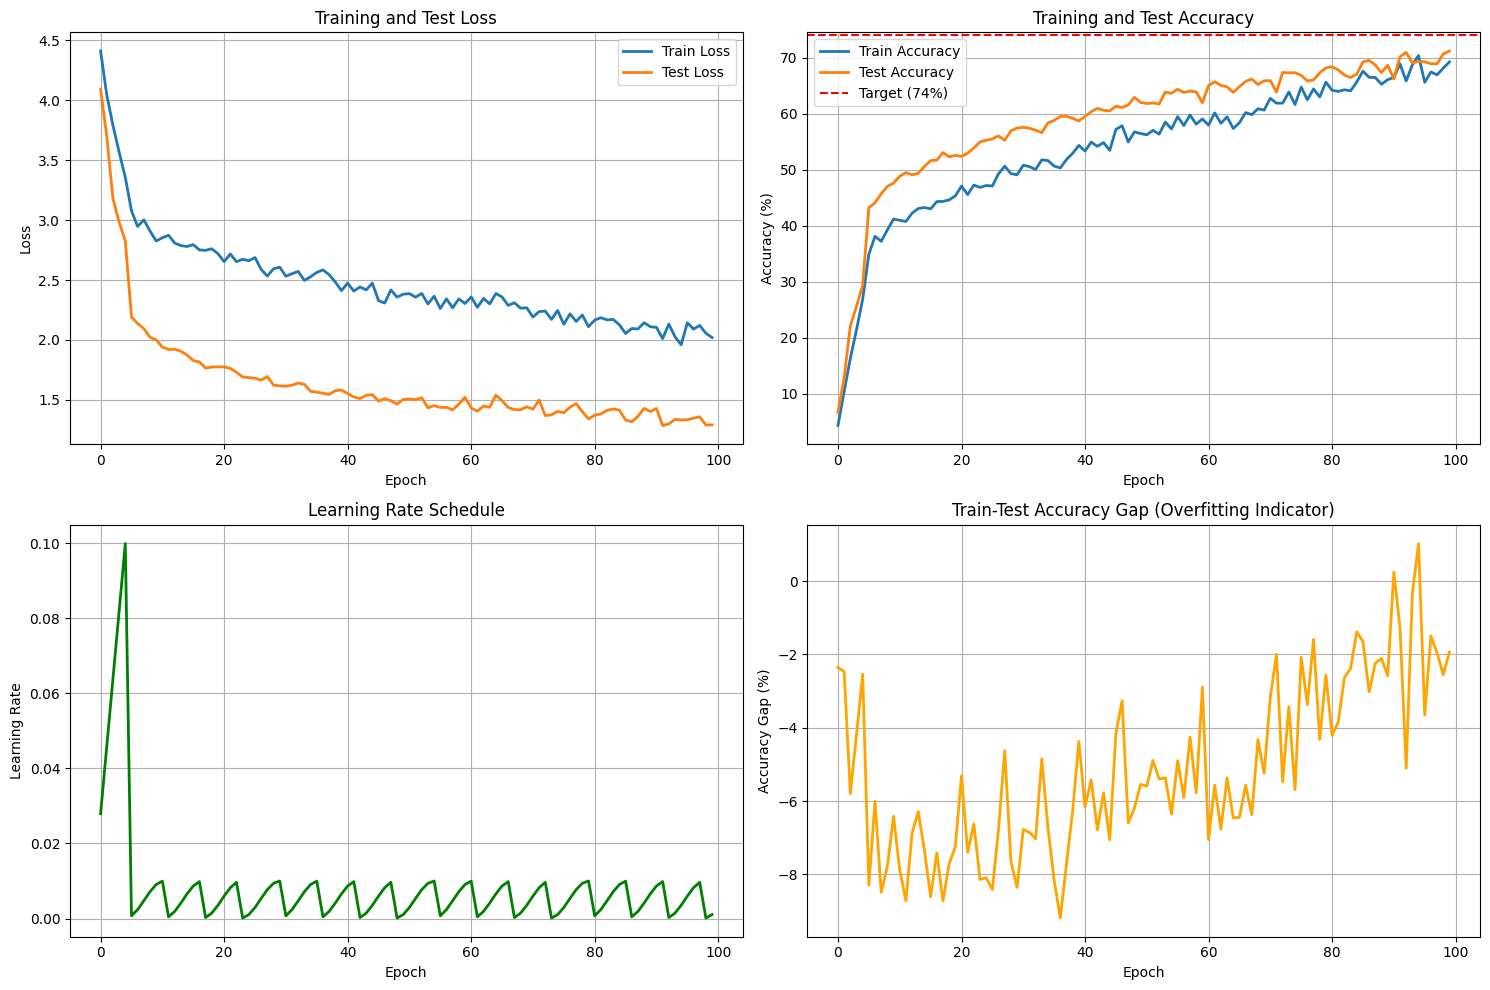

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...oints/training_curves.png:  87%|########6 |  551kB /  635kB            

✓ Uploaded: training_curves.png

Final Statistics:
Best Test Accuracy: 71.20%
Final Train Accuracy: 69.26%
Final Test Accuracy: 71.20%
Final Train-Test Gap: -1.94%


In [13]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy curves
axes[0, 1].plot(train_accuracies, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accuracies, label='Test Accuracy', linewidth=2)
axes[0, 1].axhline(y=74, color='r', linestyle='--', label='Target (74%)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate
axes[1, 0].plot(learning_rates, linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)

# Gap between train and test accuracy (overfitting indicator)
accuracy_gap = [train - test for train, test in zip(train_accuracies, test_accuracies)]
axes[1, 1].plot(accuracy_gap, linewidth=2, color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap (%)')
axes[1, 1].set_title('Train-Test Accuracy Gap (Overfitting Indicator)')
axes[1, 1].grid(True)

plt.tight_layout()
curves_path = os.path.join(checkpoint_dir, 'training_curves.png')
plt.savefig(curves_path, dpi=300, bbox_inches='tight')
plt.show()

# Upload training curves
upload_to_huggingface(curves_path, 'training_curves.png', commit_message="Upload training curves")

print(f"\nFinal Statistics:")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Final Train-Test Gap: {accuracy_gap[-1]:.2f}%")

In [14]:
# Create and upload model card
create_and_upload_model_card(
    best_test_acc,
    len(train_accuracies),
    train_accuracies,
    test_accuracies,
    checkpoint_dir
)

# Save final config
config = {
    'model': 'WideResNet-28-10',
    'depth': 28,
    'widen_factor': 10,
    'dropout': 0.3,
    'num_classes': 100,
    'batch_size': BATCH_SIZE,
    'epochs': len(train_accuracies),
    'optimizer': 'SGD',
    'momentum': 0.9,
    'weight_decay': 1e-3,
    'initial_lr': INITIAL_LR,
    'max_lr': MAX_LR,
    'min_lr': MIN_LR,
    'scheduler': 'CosineAnnealingWarmRestarts',
    'T_0': 25,
    'warmup_epochs': WARMUP_EPOCHS,
    'mixup_alpha': 0.2,
    'label_smoothing': 0.1,
    'gradient_clipping': 1.0,
    'mixed_precision': True,
    'best_test_accuracy': best_test_acc,
    'final_train_accuracy': train_accuracies[-1],
    'final_test_accuracy': test_accuracies[-1]
}

config_path = os.path.join(checkpoint_dir, 'config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

upload_to_huggingface(config_path, 'config.json', commit_message="Upload training configuration")

print(f"\n{'=' * 70}")
print(f"All files uploaded to: https://huggingface.co/{REPO_ID}")
print(f"{'=' * 70}")

✓ Uploaded: README.md
✓ Model card created and uploaded
✓ Uploaded: config.json

All files uploaded to: https://huggingface.co/pandurangpatil/cifar100-wideresnet-session8


In [15]:
# Load best model and evaluate
checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with test accuracy: {checkpoint['test_accuracy']:.2f}%")

# Final evaluation
test_loss, test_acc = test(model, device, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

Loaded best model from epoch 100 with test accuracy: 71.20%

Test set: Average loss: 1.2912, Accuracy: 7120/10000 (71.20%)


Final Test Accuracy: 71.20%


In [16]:
# Optional: Download and resume from checkpoint
# Uncomment to use

# from huggingface_hub import hf_hub_download

# # Download a specific checkpoint
# checkpoint_path = hf_hub_download(
#     repo_id=REPO_ID,
#     filename="checkpoint_epoch50.pth",
#     token=HF_TOKEN
# )

# # Load checkpoint
# checkpoint = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# print(f"Resumed from epoch {checkpoint['epoch']} with test accuracy {checkpoint['test_accuracy']:.2f}%")